In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

### K-mean standard

In [2]:
class KMeans:
    """
    Implements the K-means clustering algorithm from scratch using NumPy.
    Parameters:
    ----------
    K (int): The number of clusters (default=3)
    max_iter (int): The maximum number of iterations to run (default=100)
    tol (float): Tolerance for convergence. The algorithm stops if the centroids 
                 move less than this distance (default=10e-4) 
    """
    def __init__(self, K=3, max_iter=100, tol=1e-4, n_init=10, random_state=None):
        self.K = K
        self.max_iter = max_iter
        self.tol = tol
        self.n_init = n_init

        if random_state:
            np.random.seed(random_state)

        self.centroids = None # Stores the final centroids
        self.labels_ = None   # Stores the final labels for each data point
        self.inertia_ = None   # Stores best WCSS

    def _init_centroids(self, X):
        """
        Initializes the centroids by randomly selecting K points from the
        dataset X.

        Note: This is the simple "random" method. K-means++ is a 
        superior initialization strategy.
        """
        n_samples, _ = X.shape
        rand_indices = np.random.choice(n_samples, self.K, replace=False)
        centroids = X[rand_indices]
        return centroids
    
    def _assign_labels(self, X, centroids):
        """
        Assigns each point in X to the closest centroid.
        This is the "Assignment Step" (E-Step).
        """
        labels = []

        for point in X:
            distances_to_centroids = np.sum((centroids - point)**2, axis=1)

            closest_centroid_index = np.argmin(distances_to_centroids)
            labels.append(closest_centroid_index)

        return np.array(labels)
    
    def _update_centroids(self, X, labels):
        """
        Updates the centroids to be the mean of all points assigned to them.
        This is the "Update Step" (M-Step).
        """
        new_centroids = np.zeros((self.K, X.shape[1]))
        for k in range(self.K):
            # Get all data points assigned to cluster k
            cluster_points = X[labels == k]

            # Handle the important edge case of an empty cluster
            if len(cluster_points) > 0:
                # Calculate the mean of the points to get the new centroid
                new_centroids[k] = np.mean(cluster_points, axis=0)
            else:
                new_centroids[k] = X[np.random.choice(X.shape[0])]
        return new_centroids
    
    def _has_converged(self, old_centroids, new_centroids):
        """
        Checks if the centroids have stopped moving (within tolerance).
        """
        # Using np.allclose is a robust way to check if two arrays are
        # element-wise equal within a tolerance.
        return np.allclose(old_centroids, new_centroids, atol=self.tol)
    
    def _calculate_inertia(self, X, labels, centroids):
        total_inertia = 0
        for k in range(self.K):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                inertia_k = np.sum((cluster_points - centroids[k]) ** 2)
                total_inertia += inertia_k
        return total_inertia

    def fit(self, X):
        """
        Trains the K-means model on the dataset X.
        """

        best_inertia = np.inf
        best_centroids = None
        best_labels = None

        for i in range(self.n_init):
            current_centroids = self._init_centroids(X)
            current_labels = None

            for _ in range(self.max_iter):
                # Store old centroids to check for convergence
                old_centroids = current_centroids.copy()

                # Step 1: Assign labels (E-Step)
                current_labels = self._assign_labels(X, current_centroids)

                # Step 2: Update centroids (M-Step)
                current_centroids = self._update_centroids(X, current_labels)

                # Step 3: Check for convergence
                if self._has_converged(old_centroids, current_centroids):
                    break
                
            current_inertia = self._calculate_inertia(X, current_labels, current_centroids)
            if current_inertia < best_inertia:
                best_inertia = current_inertia
                best_centroids = current_centroids.copy()
                best_labels = current_labels.copy()
        
        self.centroids = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_inertia

    def predict(self, X_new):
        """
        Predicts the cluster for new data points X_new using the
        already trained centroids.
        """
        if self.centroids is None:
            raise RuntimeError("Model has not been fitted yet. Call .fit() first.")
        # This is just the assignment step
        return self._assign_labels(X_new, self.centroids)

### Test

#### Create data

In [3]:
X, y_true = make_blobs(n_samples=300, 
                       centers=4, 
                       cluster_std=0.80, 
                       random_state=42)

#### Initialize and train the model

In [4]:
kmeans = KMeans(K=4, max_iter=100, n_init=10, random_state=42)
kmeans.fit(X)

#### Get the results

In [5]:
labels = kmeans.labels_
centroids = kmeans.centroids
inertia = kmeans.inertia_

#### Plot the results

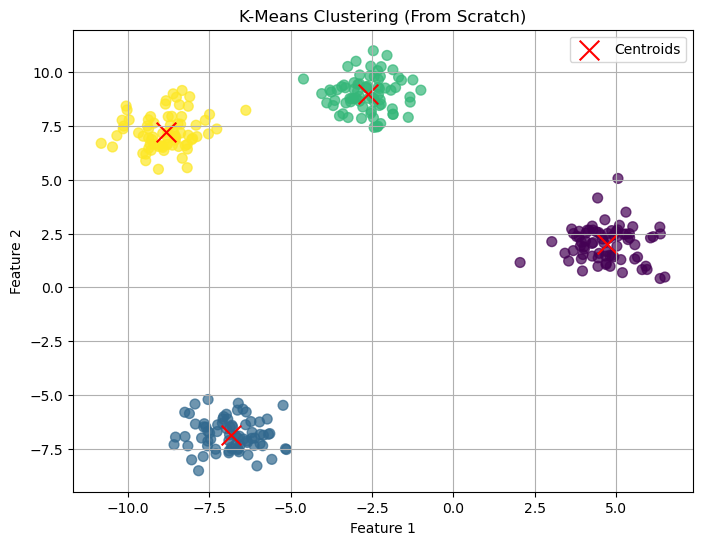

In [6]:
plt.figure(figsize=(8, 6))

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", s=50, alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c="red", marker="x", s=200, label="Centroids")

plt.title('K-Means Clustering (From Scratch)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

### Kmeans++

In [ ]:
class KMeanspp:
    """
    Implements K-Means "from scratch" with K-means++ and n_init.
    
    Parameters:
    ----------
    K (int): The number of clusters
    max_iter (int): Maximum iterations for a SINGLE run
    tol (float): Convergence threshold
    n_init (int): Number of K-means runs with different centroid seeds
    random_state (int): For reproducible results
    """
    def __init__(self, K=3, max_iter=100, tol=1e-4, n_init=10, random_state=None):
        self.K = K
        self.max_iter = max_iter
        self.tol = tol
        self.n_init = n_init

        if random_state:
            np.random.seed(random_state)

        self.centroids = None
        self.labels_ = None
        self.inertia_ = None

    def _init_centroids_kmeans_pp(self, X):
        """
        Initializes centroids using K-means++ (instead of random).
        """
        n_samples, _ = X.shape
        centroids = []

        first_centroid_index = np.random.choice(n_samples)
        centroids.append(X[first_centroid_index])
        min_distances_sq_all_points = np.zeros(n_samples)

        for _ in range(self.K - 1):
            centroids_arr = np.array(centroids)

            for i in range(n_samples):
                point = X[i]
                # Calculate D(x_n)^2: The squared distance FROM EACH POINT
                # to the NEAREST ALREADY-SELECTED CENTROID.
                distances_sq_vec = np.sum((point - centroids_arr)**2, axis=1)

                min_dist_sq_for_this_point = np.min(distances_sq_vec)
                min_distances_sq_all_points[i] = min_dist_sq_for_this_point
        
            # Calculate probabilities P(x_n) and select
            total_dist_sq = np.sum(min_distances_sq_all_points)

            if total_dist_sq == 0:
                probabilities = np.ones(n_samples) / n_samples
            else:
                probabilities = min_distances_sq_all_points / total_dist_sq

            # Spin the Roulette Wheel
            next_centroid_idx = np.random.choice(n_samples, p=probabilities)
            centroids.append(X[next_centroid_idx])
        return np.array(centroids)
    
    def _assign_labels(self, X, centroids):
        """Assigns labels based on the GIVEN centroids."""
        labels = []

        for point in X:
            distances_to_centroids = np.sum((centroids - point)**2, axis=1)
            closest_centroid_index = np.argmin(distances_to_centroids)
            labels.append(closest_centroid_index)
        return np.array(labels)
    
    def _update_centroids(self, X, labels):
        """Updates centroids based on the GIVEN labels."""
        new_centroids = np.zeros((self.K, X.shape[1]))
        for k in range(self.K):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centroids[k] = np.mean(cluster_points, axis=0)
            else:
                new_centroids[k] = X[np.random.choice(X.shape[0])]
        return new_centroids
    
    def _has_converged(self, old_centroids, new_centroids):
        """Checks if the two sets of centroids have converged."""
        return np.allclose(old_centroids, new_centroids, atol=self.tol)
    
    def _calculate_inertia(self, X, labels, centroids):
        """Calculates WCSS for the GIVEN labels and centroids."""
        total_inertia = 0
        for k in range(self.K):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                inertia_k = np.sum((cluster_points - centroids[k]) ** 2)
                total_inertia += inertia_k
        return total_inertia
    
    def fit(self, X):
        """
        Trains the model, runs n_init times, and selects the best result.
        """
        best_inertia = np.inf
        best_centroids = None
        best_labels = None

        for i in range(self.n_init):
            # Initialize centroids for THIS RUN (using K-means++)
            current_centroids = self._init_centroids_kmeans_pp(X)

            # MAX_ITER loop (the turns within one game)
            for _ in range(self.max_iter):
                old_centroids = current_centroids.copy()

                # Step 1: Assign labels
                current_labels = self._assign_labels(X, current_centroids)

                # Step 2: Update centroids
                current_centroids = self._update_centroids(X, current_labels)

                # Step 3: Check for convergence
                if self._has_converged(old_centroids, current_centroids):
                    break
            
            # Calculate inertia for THIS RUN
            current_inertia = self._calculate_inertia(X, current_labels, current_centroids)
            # Save the result if it's better
            if current_inertia < best_inertia:
                best_inertia = current_inertia
                best_centroids = current_centroids.copy()
                best_labels = current_labels.copy()
        
        # Only assign the BEST results to self. after all runs are complete
        self.centroids = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_inertia

    def predict(self, X_new):
        """
        Predicts clusters for new data.
        """
        if self.centroids is None:
            raise RuntimeError("Model has not been fitted yet. Call .fit() first.")
        
        return self._assign_labels(X_new, self.centroids)

In [8]:
def find_optimal_k_silhouette(X, max_k, random_state=42):
    """
    Runs the "from scratch" KMeans class with different K values
    and finds the best K using Silhouette Score.
    """
    silhouette_scores = {} # Stores K and its score
    k_range = range(2, max_k + 1)
    
    print(f"Running Silhouette analysis for K from 2 to {max_k}...")
    
    for k in k_range:
        kmeans_model = KMeans(
            K=k, 
            n_init=10, 
            max_iter=200, 
            random_state=random_state
        )
        
        kmeans_model.fit(X)
        
        # Get labels and calculate score
        labels = kmeans_model.labels_
        # Use scikit-learn's silhouette_score function
        score = silhouette_score(X, labels) 
        
        silhouette_scores[k] = score
        print(f"  K = {k}, Silhouette Score = {score:.4f}")
    
    # --- Plot the results ---
    plt.figure(figsize=(8, 5))
    plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), 'bo-')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Average Silhouette Score')
    plt.title('Silhouette Score (From Scratch K-Means)')
    plt.grid(True)
    plt.show()
    
    # Find the best K
    best_k = max(silhouette_scores, key=silhouette_scores.get)
    print(f"\nBest K is: K = {best_k} (with the highest score of {silhouette_scores[best_k]:.4f})")
    
    return best_k, silhouette_scores

Running Silhouette analysis for K from 2 to 10...
  K = 2, Silhouette Score = 0.5700
  K = 3, Silhouette Score = 0.7642
  K = 4, Silhouette Score = 0.8386
  K = 5, Silhouette Score = 0.7082
  K = 6, Silhouette Score = 0.5833
  K = 7, Silhouette Score = 0.4469
  K = 8, Silhouette Score = 0.4581
  K = 9, Silhouette Score = 0.3511
  K = 10, Silhouette Score = 0.3630


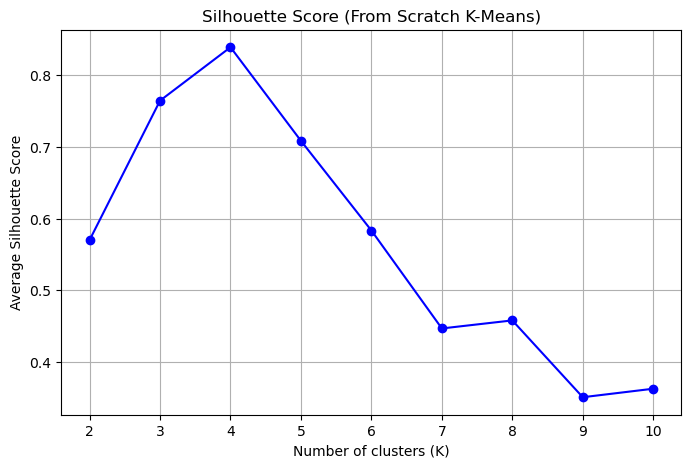


Best K is: K = 4 (with the highest score of 0.8386)

Training final model with K = 4...
Done! Final Inertia: 11.32


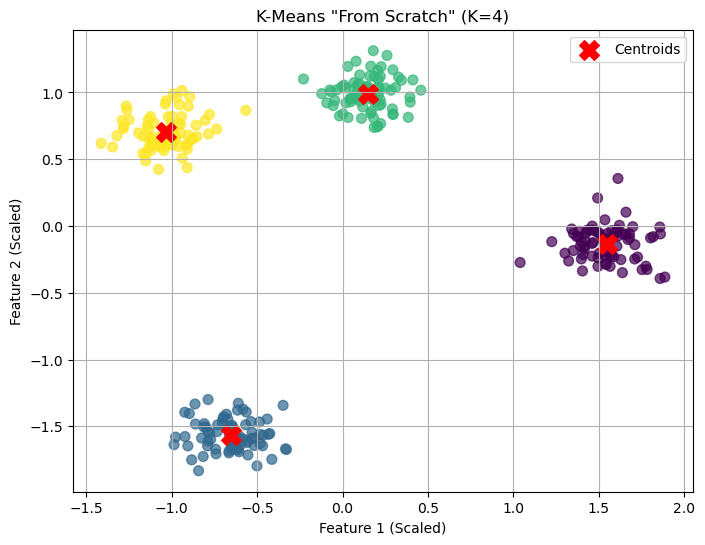

In [9]:
# 1. Create data
X_raw, y_true = make_blobs(n_samples=300, 
                           centers=4, 
                           cluster_std=0.80, 
                           random_state=42)
# Always scale your data!
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)


# 2. RUN THE K-FINDING FUNCTION:
best_k, scores = find_optimal_k_silhouette(X, max_k=10, random_state=42)


# 3. Train the final model with the best K
print(f"\nTraining final model with K = {best_k}...")

final_kmeans = KMeans(K=best_k, n_init=10, random_state=42)
final_kmeans.fit(X)

print(f"Done! Final Inertia: {final_kmeans.inertia_:.2f}")

# 4. Visualize the final result
labels = final_kmeans.labels_
centroids = final_kmeans.centroids

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title(f'K-Means "From Scratch" (K={best_k})')
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')
plt.legend()
plt.grid(True)
plt.show()